In [1]:
import warnings

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

from get_data import get_balanced_exoplanet_data, get_scaled_balanced_exoplanet_data

warnings.simplefilter("ignore")

In [2]:
x_train, x_test, y_train, y_test = get_balanced_exoplanet_data()
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = get_scaled_balanced_exoplanet_data()

## Try without scaling

0.9297029702970298


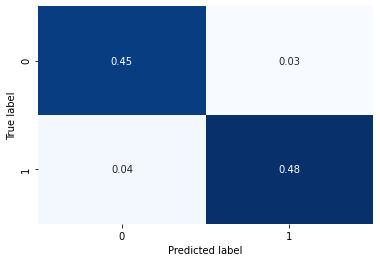

In [3]:
# Parameters
rng_seed = 2023  # random number generator seed
eta_0 = 0.1  # starting learning rate
nodes = [10]  # hidden layer nodes
activation = "relu"  # hidden activation
n_epochs = 100  # number of epochs
lmbda = 0.001  # l2 regularization
solver = "adam"  # solver algorithm
cmap = "Blues"  # confusion matrix colormap
fmt = ".2f"  # confusion matrix format


model = MLPClassifier(
    hidden_layer_sizes=nodes,
    solver=solver,
    activation=activation,
    alpha=lmbda,
    learning_rate_init=eta_0,
    max_iter=n_epochs,
    random_state=rng_seed,
)
model.fit(x_train, y_train)
pred = model.predict(x_test)

# Confusion matrix
sns.heatmap(
    confusion_matrix(y_test, pred, normalize="all"),
    annot=True,
    cmap=cmap,
    cbar=False,
    fmt=fmt,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Metrics
print(accuracy_score(y_test, pred))

## Try with scaling

0.9896039603960396


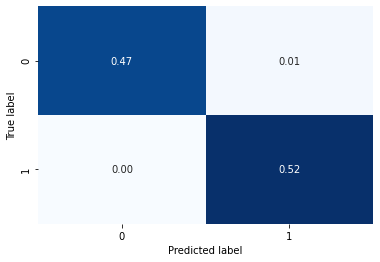

In [4]:
model = MLPClassifier(
    hidden_layer_sizes=nodes,
    solver=solver,
    activation=activation,
    alpha=lmbda,
    learning_rate_init=eta_0,
    max_iter=n_epochs,
    random_state=rng_seed,
)

model.fit(x_train_scaled, y_train_scaled)
pred = model.predict(x_test_scaled)

# Confusion matrix
sns.heatmap(
    confusion_matrix(y_test_scaled, pred, normalize="all"),
    annot=True,
    cmap=cmap,
    cbar=False,
    fmt=fmt,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Metrics
print(accuracy_score(y_test_scaled, pred))

#### Scaling does not improve performance

## Try more than one hidden layer

0.5227722772277228


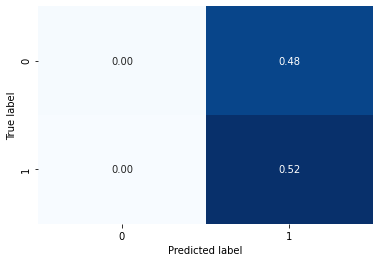

In [5]:
# Parameters
n_nodes2 = [10, 10, 10]  # hidden layer nodes

model = MLPClassifier(
    hidden_layer_sizes=n_nodes2,
    solver=solver,
    activation=activation,
    alpha=lmbda,
    learning_rate_init=eta_0,
    max_iter=n_epochs,
    random_state=rng_seed,
)

model.fit(x_train_scaled, y_train_scaled)
pred = model.predict(x_test_scaled)

# Confusion matrix
sns.heatmap(
    confusion_matrix(y_test_scaled, pred, normalize="all"),
    annot=True,
    cmap="Blues",
    cbar=False,
    fmt=fmt,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Metrics
print(accuracy_score(y_test_scaled, pred))

### Using only one hidden layer is significantly better

## Try using other activation functions

In [6]:
# Parameters
activations = ["identity", "logistic", "tanh"]  # hidden layer nodes

for activation_i in activations:
    model = MLPClassifier(
        hidden_layer_sizes=nodes,
        solver=solver,
        activation=activation_i,
        alpha=lmbda,
        learning_rate_init=eta_0,
        max_iter=n_epochs,
        random_state=rng_seed,
    )

    model.fit(x_train_scaled, y_train_scaled)
    pred = model.predict(x_test_scaled)

    # Metrics
    print(f"activation={activation_i}")
    print(accuracy_score(y_test_scaled, pred))
    print()

activation=identity
0.800990099009901

activation=logistic
0.5331683168316832

activation=tanh
0.5277227722772277



### Relu has the best performance

## Grid search for parameters $\eta$ and $\lambda$

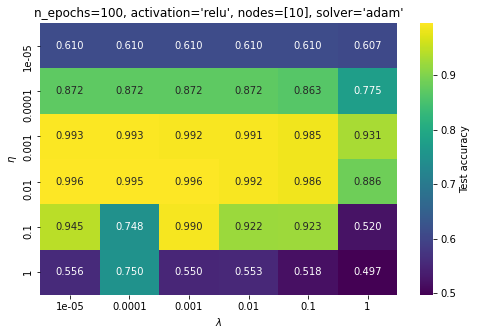

In [7]:
# Parameters
eta_vals = np.logspace(-5, 0, 6)
lmbd_vals = np.logspace(-5, 0, 6)
figsize = 8, 5
filename = "../results/figures/nn_gridsearch_eta_lambda.png"

accuracies = np.zeros((eta_vals.size, lmbd_vals.size))
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        model = MLPClassifier(
            hidden_layer_sizes=nodes,
            solver=solver,
            activation=activation,
            alpha=lmbd,
            learning_rate_init=eta,
            max_iter=n_epochs,
            random_state=rng_seed,
        )

        model.fit(x_train_scaled, y_train_scaled)
        pred = model.predict(x_test_scaled)
        accuracies[i, j] = accuracy_score(y_test_scaled, pred)

# heatmap
plt.figure(figsize=figsize)
sns.heatmap(
    accuracies,
    annot=True,
    fmt=".3f",
    xticklabels=[f"{lmbd:g}" for lmbd in lmbd_vals],
    yticklabels=[f"{eta:g}" for eta in eta_vals],
    cbar_kws={"label": "Test accuracy"},
    cmap="viridis",
)
plt.title(f"{n_epochs=}, {activation=}, {nodes=}, {solver=}")
plt.xlabel("$\lambda$")
plt.ylabel("$\eta$")

if filename:
    plt.savefig(filename)
plt.show()

## Grid search of parameters n_batches, n_nodes with one layer

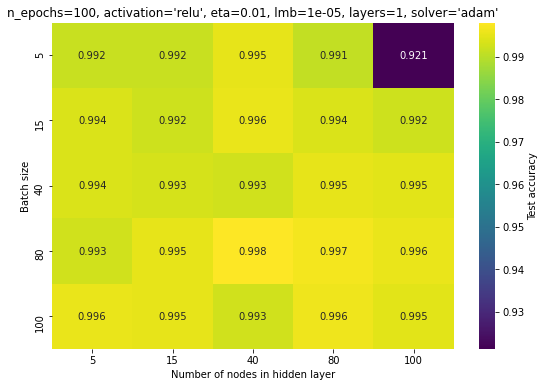

In [13]:
# Parameters
batch_size_vals = [5, 15, 40, 80, 100]  # minibatch size
node_vals = [(5,), (15,), (40,), (80,), (100,)]
figsize = 9, 6
filename = "../results/figures/nn_gridsearch_batches_nodes.png"
eta = 0.01  # starting learning rate
lmb = 1e-5  # l2 regularization
n_epochs = 100

accuracies = np.zeros((len(batch_size_vals), len(node_vals)))
for i, batch_size in enumerate(batch_size_vals):
    for j, nodes in enumerate(node_vals):
        model = MLPClassifier(
            hidden_layer_sizes=nodes,
            solver=solver,
            activation=activation,
            alpha=lmb,
            learning_rate_init=eta,
            max_iter=n_epochs,
            random_state=rng_seed,
            batch_size=batch_size,
        )

        model.fit(x_train_scaled, y_train_scaled)
        pred = model.predict(x_test_scaled)
        accuracies[i, j] = accuracy_score(y_test_scaled, pred)

# heatmap
plt.figure(figsize=figsize)
sns.heatmap(
    accuracies,
    annot=True,
    fmt=".3f",
    xticklabels=[f"{nodes[0]}" for nodes in node_vals],
    yticklabels=[f"{batches}" for batches in batch_size_vals],
    cbar_kws={"label": "Test accuracy"},
    cmap="viridis",
)
plt.title(f"{n_epochs=}, {activation=}, {eta=}, {lmb=}, layers=1, {solver=}")
plt.xlabel("Number of nodes in hidden layer")
plt.ylabel("Batch size")

if filename:
    plt.savefig(filename)
plt.show()

# Plot final result with optimal parameters

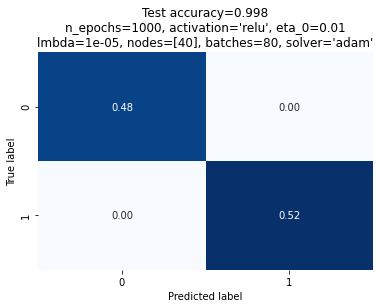

In [17]:
# Parameters
rng_seed = 2023  # random number generator seed
eta_0 = 0.01  # starting learning rate
lmbda = 1e-5  # l2 regularization
batches = 80  # no. batches
nodes = [40]  # hidden layer nodes
activation = "relu"  # hidden activation
n_epochs = 1000  # number of epochs
solver = "adam"  # solver algorithm
filename = "../results/figures/nn_class_conf_matrix.png"


plt.figure(figsize=(7))
model = MLPClassifier(
    hidden_layer_sizes=nodes,
    solver=solver,
    activation=activation,
    alpha=lmbda,
    learning_rate_init=eta_0,
    max_iter=n_epochs,
    random_state=rng_seed,
    batch_size=batches,
)
model.fit(x_train_scaled, y_train_scaled)
pred = model.predict(x_test_scaled)

# Confusion matrix
sns.heatmap(
    confusion_matrix(y_test_scaled, pred, normalize="all"),
    annot=True,
    cmap=cmap,
    cbar=False,
    fmt=fmt,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Test accuracy={accuracy_score(y_test_scaled, pred):.3f}\n"
        + f"{n_epochs=}, {activation=}, {eta_0=}\n{lmbda=}, {nodes=}, {batches=}, {solver=}")
plt.savefig(filename)
plt.show();